<a href="https://colab.research.google.com/github/MatthewSebastian15/Automated-Portfolio-Management/blob/main/Indonesian_Blue_Chip_Stocks/Actual%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Portfolio Management**
## **(ADRO, AMRT, ASII, BBCA, BBNI, BBRI, BMRI, ICBP, ISAT, MDKA, MYOR, TLKM)**

In [ ]:
# VISUALISASI
# - Volatility Analysis
# - Sharpe Ratio Analysis
# - Cumulative Returns
# - Sortino Ratio

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import plotly.graph_objects as go
from scipy.optimize import fsolve
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [2]:
TICKERS = [
    'ADRO.JK', # PT Adaro Energy Indonesia Tbk
    'AMRT.JK', # PT Sumber Alfaria Trijaya Tbk
    'ASII.JK', # PT Astra International Tbk
    'BBCA.JK', # PT Bank Central Asia Tbk
    'BBNI.JK', # PT Bank Negara Indonesia (Persero) Tbk
    'BBRI.JK', # PT Bank Rakyat Indonesia (Persero) Tbk
    'BMRI.JK', # PT Bank Mandiri (Persero) Tbk
    'BRPT.JK', # PT Barito Pacific Tbk
    'CPIN.JK', # PT Charoen Pokphand Indonesia Tbk
    'EXCL.JK', # PT XL Axiata Tbk
    'ICBP.JK', # PT Indofood CBP Sukses Makmur Tbk
    'INDF.JK', # PT Indofood Sukses Makmur Tbk
    'ISAT.JK', # PT Indosat Ooredoo Hutchison Tbk
    'KLBF.JK', # PT Kalbe Farma Tbk
    'MDKA.JK', # PT Merdeka Copper Gold Tbk
    'MYOR.JK', # PT Mayora Indah Tbk
    'TLKM.JK', # PT Telkom Indonesia (Persero) Tbk
    'TPIA.JK', # PT Chandra Asri Pacific Tbk
    'UNTR.JK', # PT United Tractors Tbk
    'UNVR.JK'  # PT Unilever Indonesia Tbk
]

START_DATE = '2006-01-01'
END_DATE = '2025-12-31'

In [3]:
# LOAD DATA
def load_data(tickers, start, end):
    raw_data = yf.download(tickers, start=start, end=end, auto_adjust=False)
    prices = raw_data['Adj Close'].ffill().bfill()
    volumes = raw_data['Volume'].ffill().bfill()
    shares_outstanding = {}
    for t in tickers:
        ticker_obj = yf.Ticker(t)
        shares = ticker_obj.info.get('sharesOutstanding')
        shares_outstanding[t] = shares

    market_cap_hist = prices.copy()
    for t in tickers:
        if shares_outstanding[t]:
            market_cap_hist[t] = prices[t] * shares_outstanding[t]
        else:
            market_cap_hist[t] = np.nan

    log_returns = np.log(prices / prices.shift(1))
    log_returns = log_returns.replace([np.inf, -np.inf], np.nan).dropna()
    valid_idx = log_returns.index
    return (prices.loc[valid_idx], volumes.loc[valid_idx], log_returns, market_cap_hist.loc[valid_idx])

prices, volumes, log_returns, hist_mcap = load_data(TICKERS, START_DATE, END_DATE)

[*********************100%***********************]  20 of 20 completed


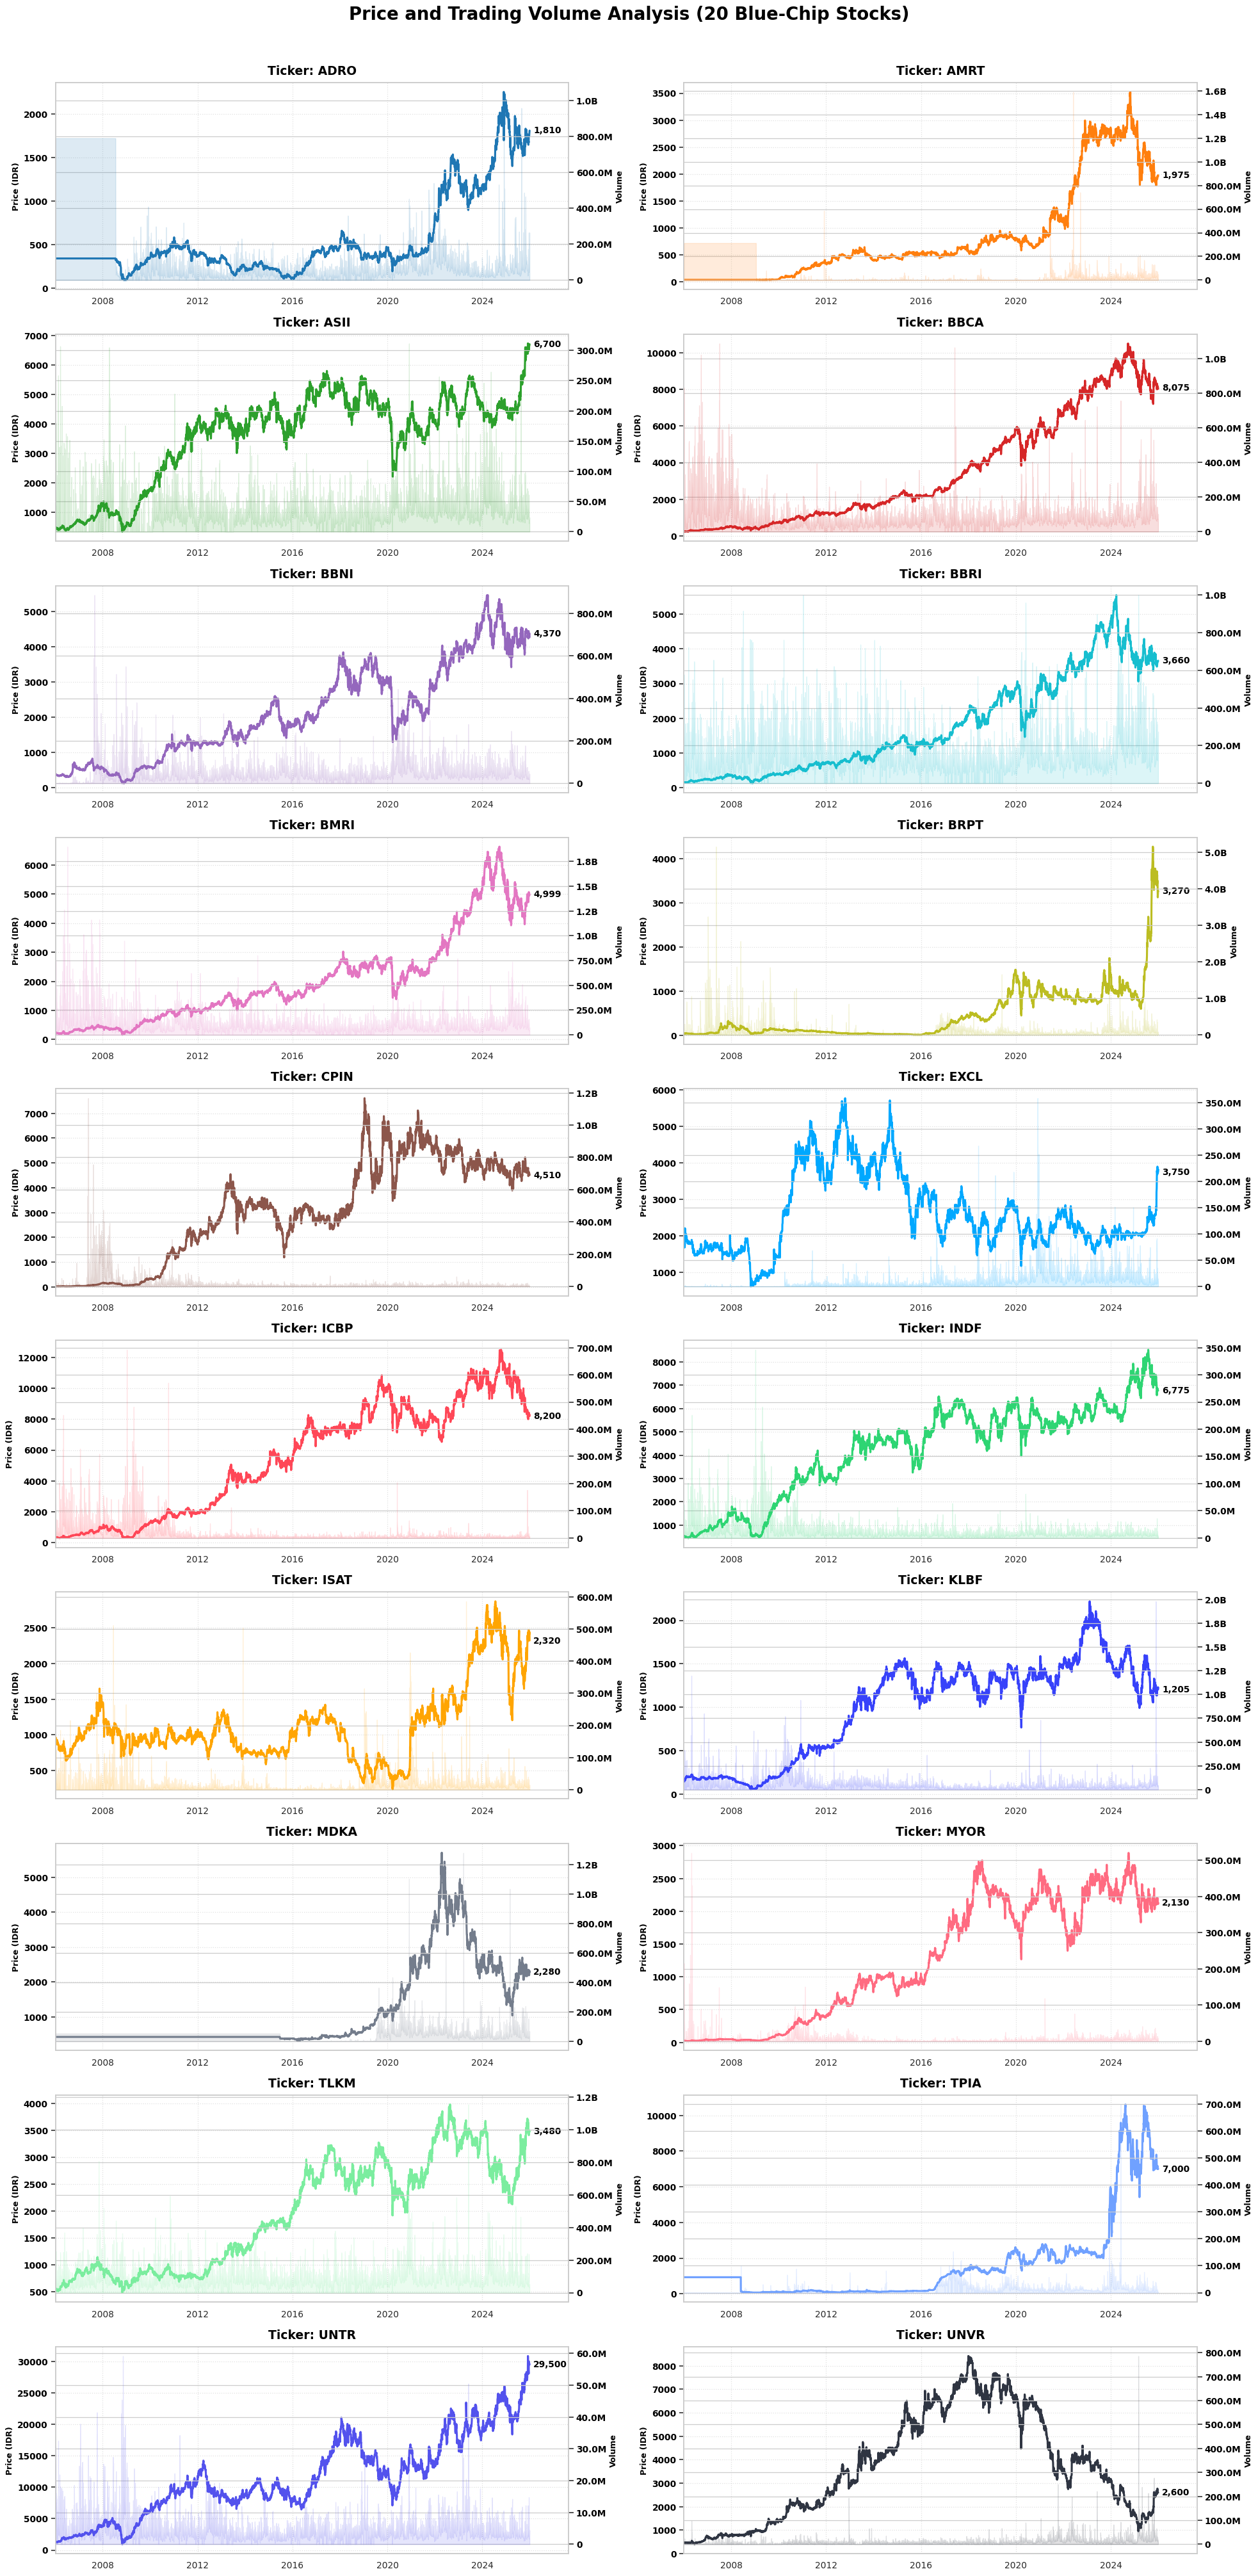

In [21]:
def volume_formatter(x, pos):
    if x >= 1e9: return f'{x*1e-9:.1f}B'
    elif x >= 1e6: return f'{x*1e-6:.1f}M'
    elif x >= 1e3: return f'{x*1e-3:.1f}K'
    return f'{x:.0f}'

plot_prices = prices.copy()
plot_volumes = volumes.copy()
plot_prices.columns = [t.replace('.JK', '') for t in plot_prices.columns]
plot_volumes.columns = [t.replace('.JK', '') for t in plot_volumes.columns]
fig, axes = plt.subplots(10, 2, figsize=(22, 45), dpi=90)
axes = axes.flatten()

colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff',
    '#ff4757', '#2ed573', '#ffa502', '#3742fa', '#747d8c',
    '#ff6b81', '#7bed9f', '#70a1ff', '#5352ed', '#2f3542'
]

for i, ticker in enumerate(plot_prices.columns):
    if i >= len(axes): break

    ax = axes[i]
    ax2 = ax.twinx()
    p_series = plot_prices[ticker]
    v_series = plot_volumes[ticker]
    main_color = colors[i]
    ax.plot(p_series.index, p_series, linewidth=2.5, color=main_color, zorder=3)
    ax.set_ylabel('Price (IDR)', fontsize=10, fontweight='bold', color='black')
    ax2.fill_between(v_series.index, v_series, 0, color=main_color, alpha=0.15, zorder=1)
    ax2.yaxis.set_major_formatter(FuncFormatter(volume_formatter))
    ax2.set_ylabel('Volume', fontsize=10, color='black', fontweight='bold')
    ax.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='black')

    for label in ax.get_yticklabels(): label.set_fontweight('bold')
    for label in ax2.get_yticklabels(): label.set_fontweight('bold')

    last_val = p_series.iloc[-1]
    ax.text(p_series.index[-1] + pd.Timedelta(days=60), last_val, f"{last_val:,.0f}", fontsize=11, fontweight='bold', color='black', va='center')
    ax.set_title(f"Ticker: {ticker}", fontsize=15, fontweight='bold', pad=10, color='black')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle=':', alpha=0.6, zorder=0)
    ax.set_xlim(p_series.index[0], p_series.index[-1] + pd.Timedelta(days=600))

fig.suptitle('Price and Trading Volume Analysis (20 Blue-Chip Stocks)', fontsize=22, fontweight='bold', y=0.993, color='black')
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()

# **Trading Volume and Liquidity**

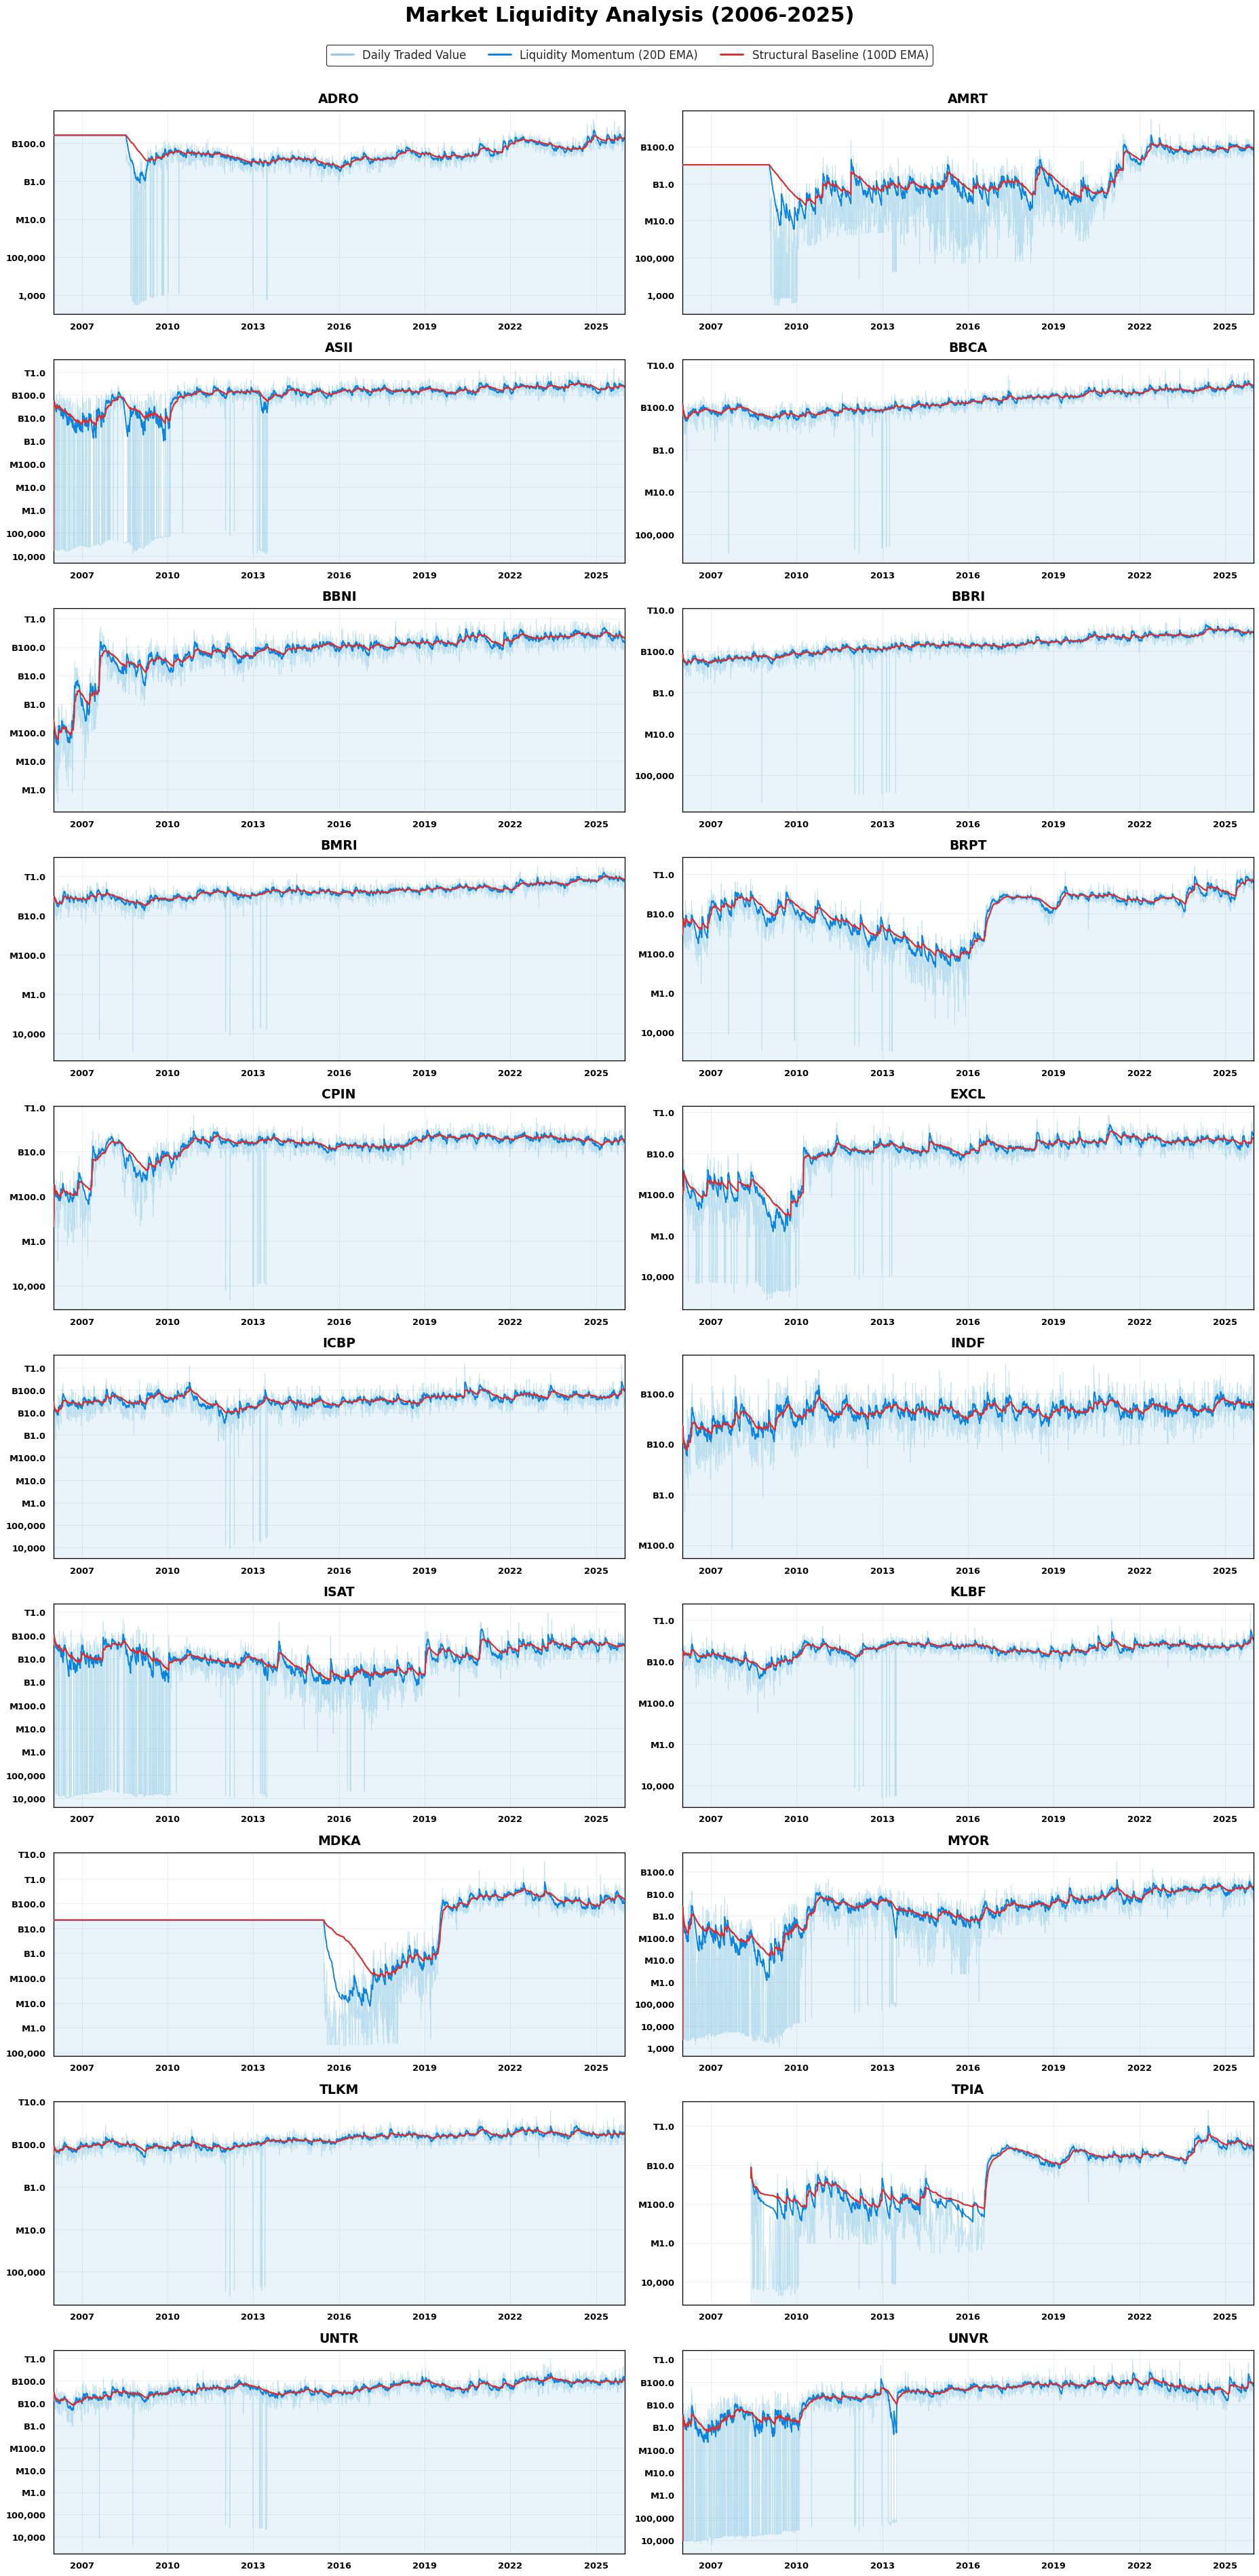

In [22]:
def value_formatter(x, pos):
    if x >= 1e12: return f'T{x*1e-12:.1f}'
    if x >= 1e9:  return f'B{x*1e-9:.1f}'
    if x >= 1e6:  return f'M{x*1e-6:.1f}'
    return f'{x:,.0f}'

data_val = (prices * volumes).loc['2006-01-01':'2025-12-31'].copy()
data_val.columns = data_val.columns.str.replace('.JK', '', regex=False)
fig, axes = plt.subplots(10, 2, figsize=(22, 45), facecolor='#ffffff', dpi=85)
axes = axes.flatten()

color_raw  = '#8ecae6'
color_fast = '#0984e3'
color_slow = '#d63031'
color_text = '#000000'
legend_lines = []

for i, col in enumerate(data_val.columns):
    if i >= len(axes): break

    ax = axes[i]
    val_series = data_val[col].replace(0, np.nan).dropna()

    if val_series.empty:
        ax.axis('off')
        continue

    ema_20  = val_series.ewm(span=20).mean()
    ema_100 = val_series.ewm(span=100).mean()
    ax.fill_between(val_series.index, val_series, color=color_raw, alpha=0.2, zorder=1)
    l1, = ax.plot(val_series.index, val_series, color=color_raw, lw=0.5, alpha=0.4, zorder=2)
    l2, = ax.plot(val_series.index, ema_20,  color=color_fast, lw=1.6, zorder=4)
    l3, = ax.plot(val_series.index, ema_100, color=color_slow, lw=1.8, zorder=5)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FuncFormatter(value_formatter))

    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_color(color_text)

    ax.set_xlim(pd.Timestamp('2006-01-01'), pd.Timestamp('2025-12-31'))
    locator = mdates.YearLocator(3)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
        label.set_color(color_text)

    ax.grid(True, which='major', axis='both', lw=0.7, color='#dfe6e9', alpha=0.7)

    for spine in ax.spines.values():
        spine.set_edgecolor(color_text)
        spine.set_linewidth(1.1)

    ax.set_title(col, fontsize=16, fontweight='bold', color=color_text, pad=10)

    if not legend_lines:
        legend_lines = [l1, l2, l3]

leg = fig.legend(legend_lines,
           ['Daily Traded Value', 'Liquidity Momentum (20D EMA)', 'Structural Baseline (100D EMA)'],
           loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=14, frameon=True, facecolor='white', edgecolor=color_text)

for line in leg.get_lines():
    line.set_linewidth(2.5)
    line.set_alpha(1.0)

fig.suptitle('Market Liquidity Analysis (2006-2025)', fontsize=26, fontweight='bold', y=0.993, color=color_text)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.show()

# **Historical Market Cap**

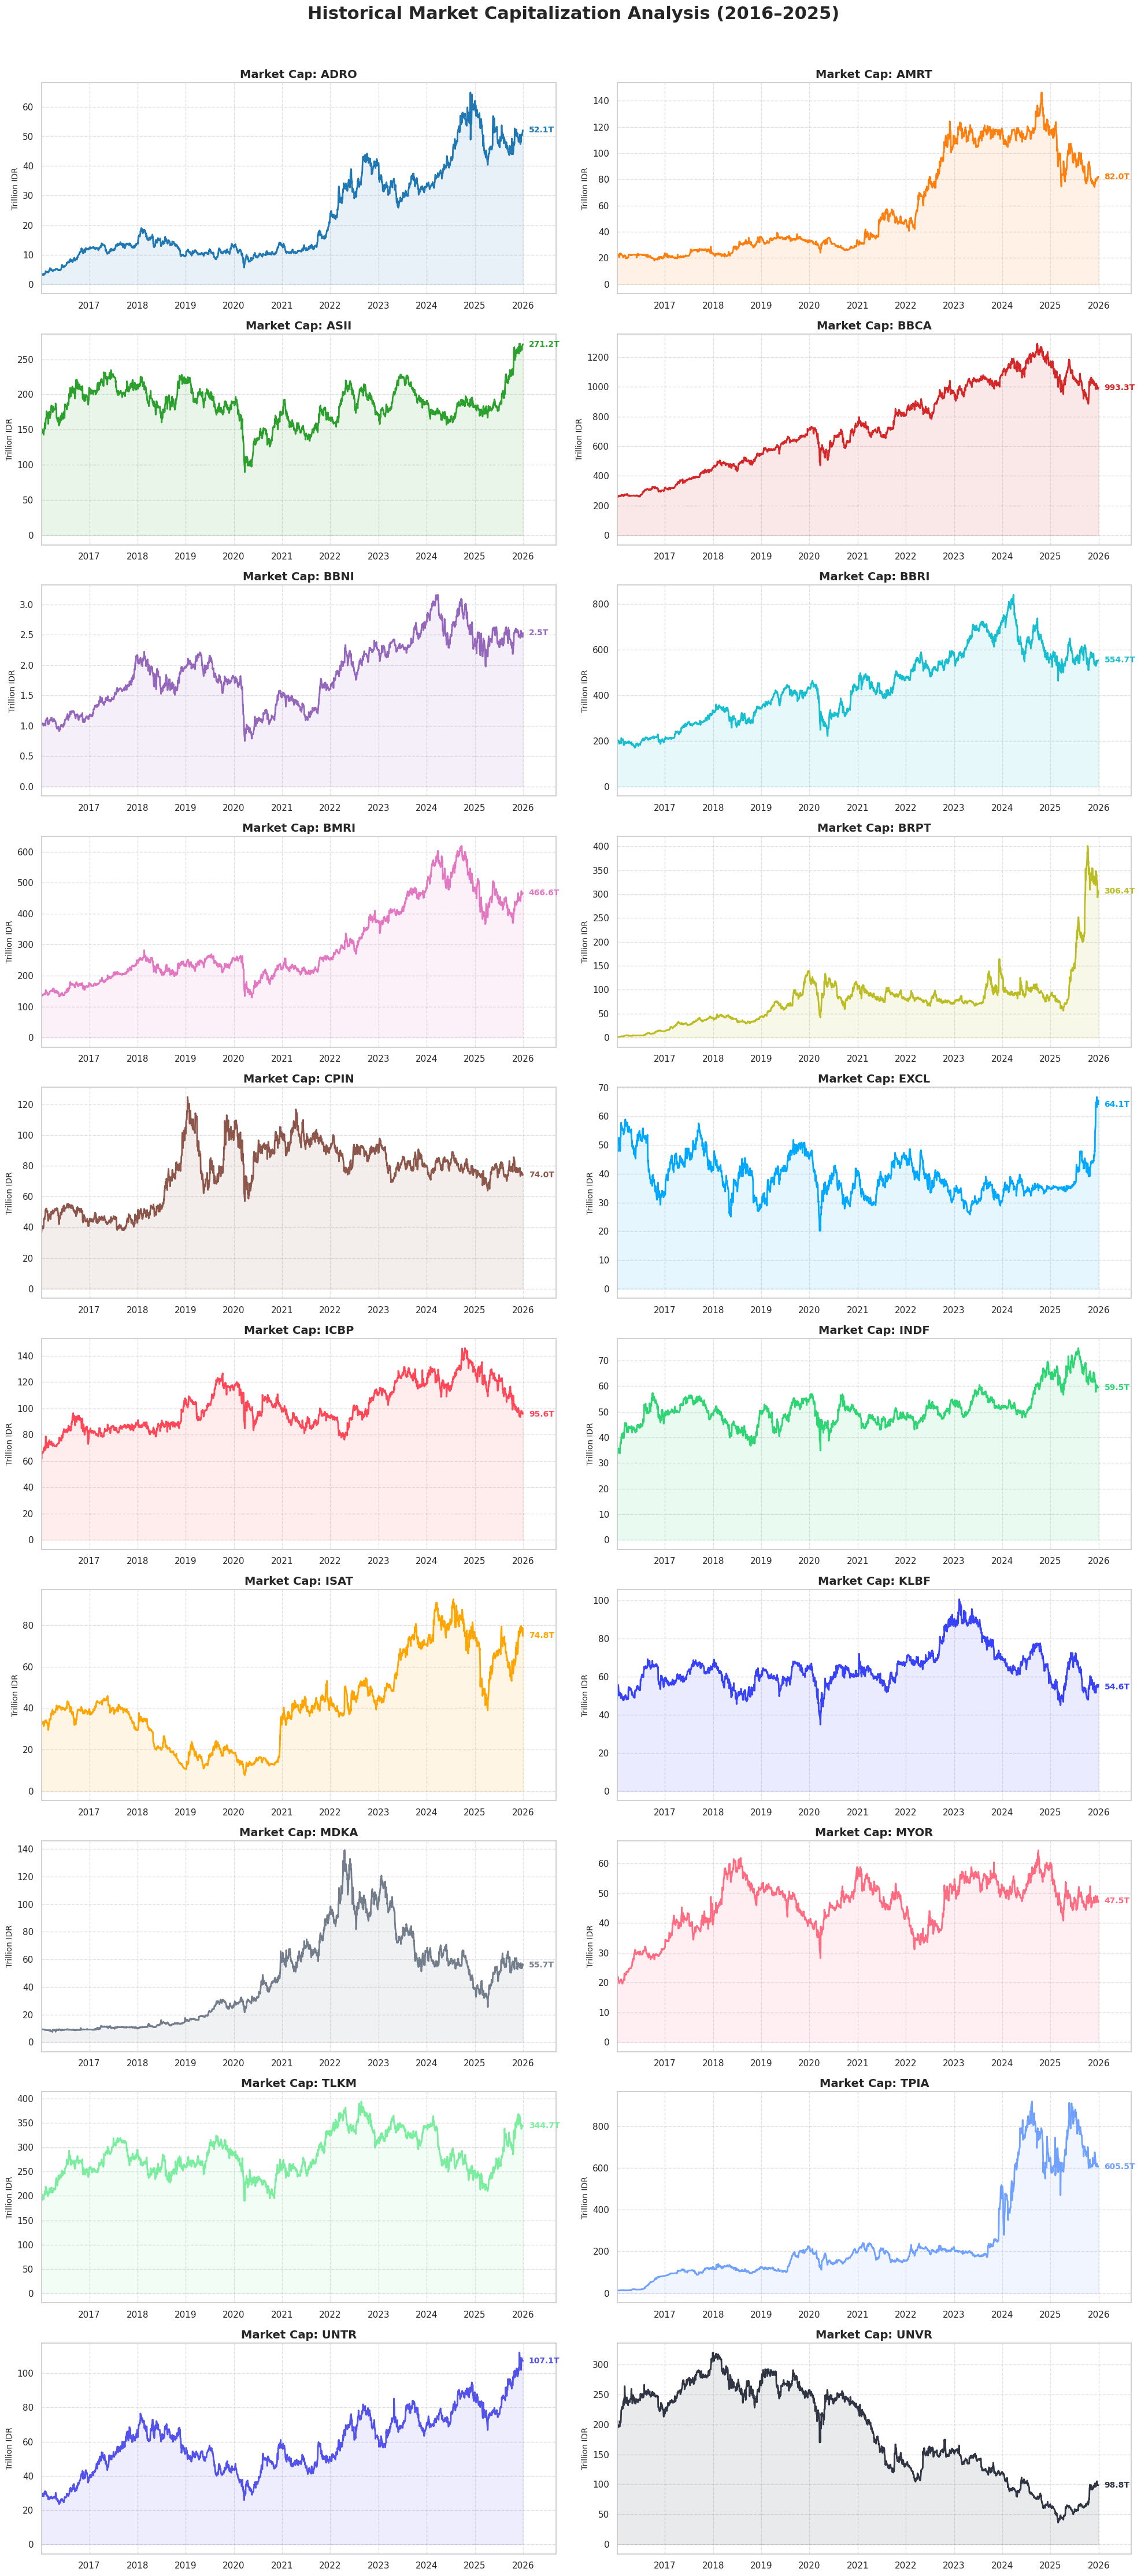

In [6]:
data_mcap = hist_mcap.loc['2016-01-01':'2025-12-31'].copy()
data_mcap.columns = data_mcap.columns.str.replace('.JK', '', regex=False)
fig, axes = plt.subplots(10, 2, figsize=(20, 45))
axes = axes.flatten()

colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff',
    '#ff4757', '#2ed573', '#ffa502', '#3742fa', '#747d8c',
    '#ff6b81', '#7bed9f', '#70a1ff', '#5352ed', '#2f3542'
]

for i, col in enumerate(data_mcap.columns):
    ax = axes[i]

    mcap_series = (data_mcap[col] / 1e12).dropna()

    if len(mcap_series) < 2:
        continue

    ax.plot(mcap_series.index, mcap_series, linewidth=2, color=colors[i])
    ax.fill_between(mcap_series.index, mcap_series, 0, color=colors[i], alpha=0.1)
    last_date = mcap_series.index[-1]
    last_value = mcap_series.iloc[-1]
    ax.text(last_date + pd.Timedelta(days=45), last_value, f"{last_value:.1f}T", fontsize=10, fontweight='bold', va='center', color=colors[i])
    ax.set_title(f"Market Cap: {col}", fontsize=14, fontweight='bold')
    ax.set_ylabel('Trillion IDR', fontsize=10)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(mcap_series.index[0], mcap_series.index[-1] + pd.Timedelta(days=250))

fig.suptitle('Historical Market Capitalization Analysis (2016–2025)', fontsize=22, y=0.99, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## **Cumulative Returns**

In [24]:
# data_actual_plot = prices.loc['2016-01-01':'2025-12-31'].copy()
# data_actual_plot.columns = data_actual_plot.columns.str.replace('.JK', '', regex=False)
# fig, ax = plt.subplots(figsize=(24, 12), facecolor='white')

# colors = [
#     '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
#     '#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff',
#     '#ff4757', '#2ed573', '#ffa502', '#3742fa', '#747d8c',
#     '#ff6b81', '#7bed9f', '#70a1ff', '#5352ed', '#2f3542'
# ]

# cum_ret_assets = {}
# for col in data_actual_plot.columns:
#     price_series = data_actual_plot[col].dropna()
#     if len(price_series) < 2:
#         continue
#     base_price = price_series.iloc[0]
#     cum_ret_assets[col] = (price_series / base_price - 1) * 100

# cum_ret_assets = pd.DataFrame(cum_ret_assets)

# for i, col in enumerate(cum_ret_assets.columns):
#     ax.plot(cum_ret_assets.index, cum_ret_assets[col], linewidth=2, alpha=0.85, label=col, color=colors[i])

# last_date = cum_ret_assets.index.max()
# offset = pd.Timedelta(days=40)
# final_vals = cum_ret_assets.loc[last_date].sort_values()

# for col in final_vals.index:
#     y = final_vals[col]
#     ax.text(last_date + offset, y, f"{col}: {y:.0f}%", fontsize=10, va='center', fontweight='bold', color='black')

# ax.set_title('Cumulative Returns Comparison (2016–2025) - 20 Stocks', fontsize=18, pad=25, fontweight='bold')
# ax.set_xlabel('Date', fontsize=12, fontweight='bold')
# ax.set_ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
# ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
# leg = ax.legend(loc='upper left', frameon=True, ncol=5, fontsize=10, facecolor='white', edgecolor='#2d3436', framealpha=1)

# for line in leg.get_lines():
#     line.set_linewidth(3.0)

# ax.grid(True, linestyle='--', alpha=0.6)
# ax.set_xlim(cum_ret_assets.index.min(), last_date + pd.Timedelta(days=600))
# plt.tight_layout()
# plt.show()

## **Drawdown Analysis**

0% Drawdown
1. Artinya portofolio tidak mengalami penurunan dari nilai tertingginya.
2. Portofolio selalu naik atau stabil, tidak ada kerugian sementara.

Drawdown positif (misal 10%, 20%)
1. Artinya portofolio turun sekian persen dari puncak sebelumnya.
2. Menunjukkan risiko penurunan nilai investasi yang pernah terjadi.

Drawdown tinggi (misal >50%)
1. Artinya portofolio mengalami penurunan besar dari puncak sebelumnya.
2. Risiko ekstrem, investor mengalami kerugian signifikan sebelum bisa kembali ke level awal.


Semakin rendah Drawdown, portofolio lebih stabil dan risiko kerugian lebih kecil.

Semakin tinggi Drawdown, portofolio lebih berisiko dan fluktuasi nilainya besar.

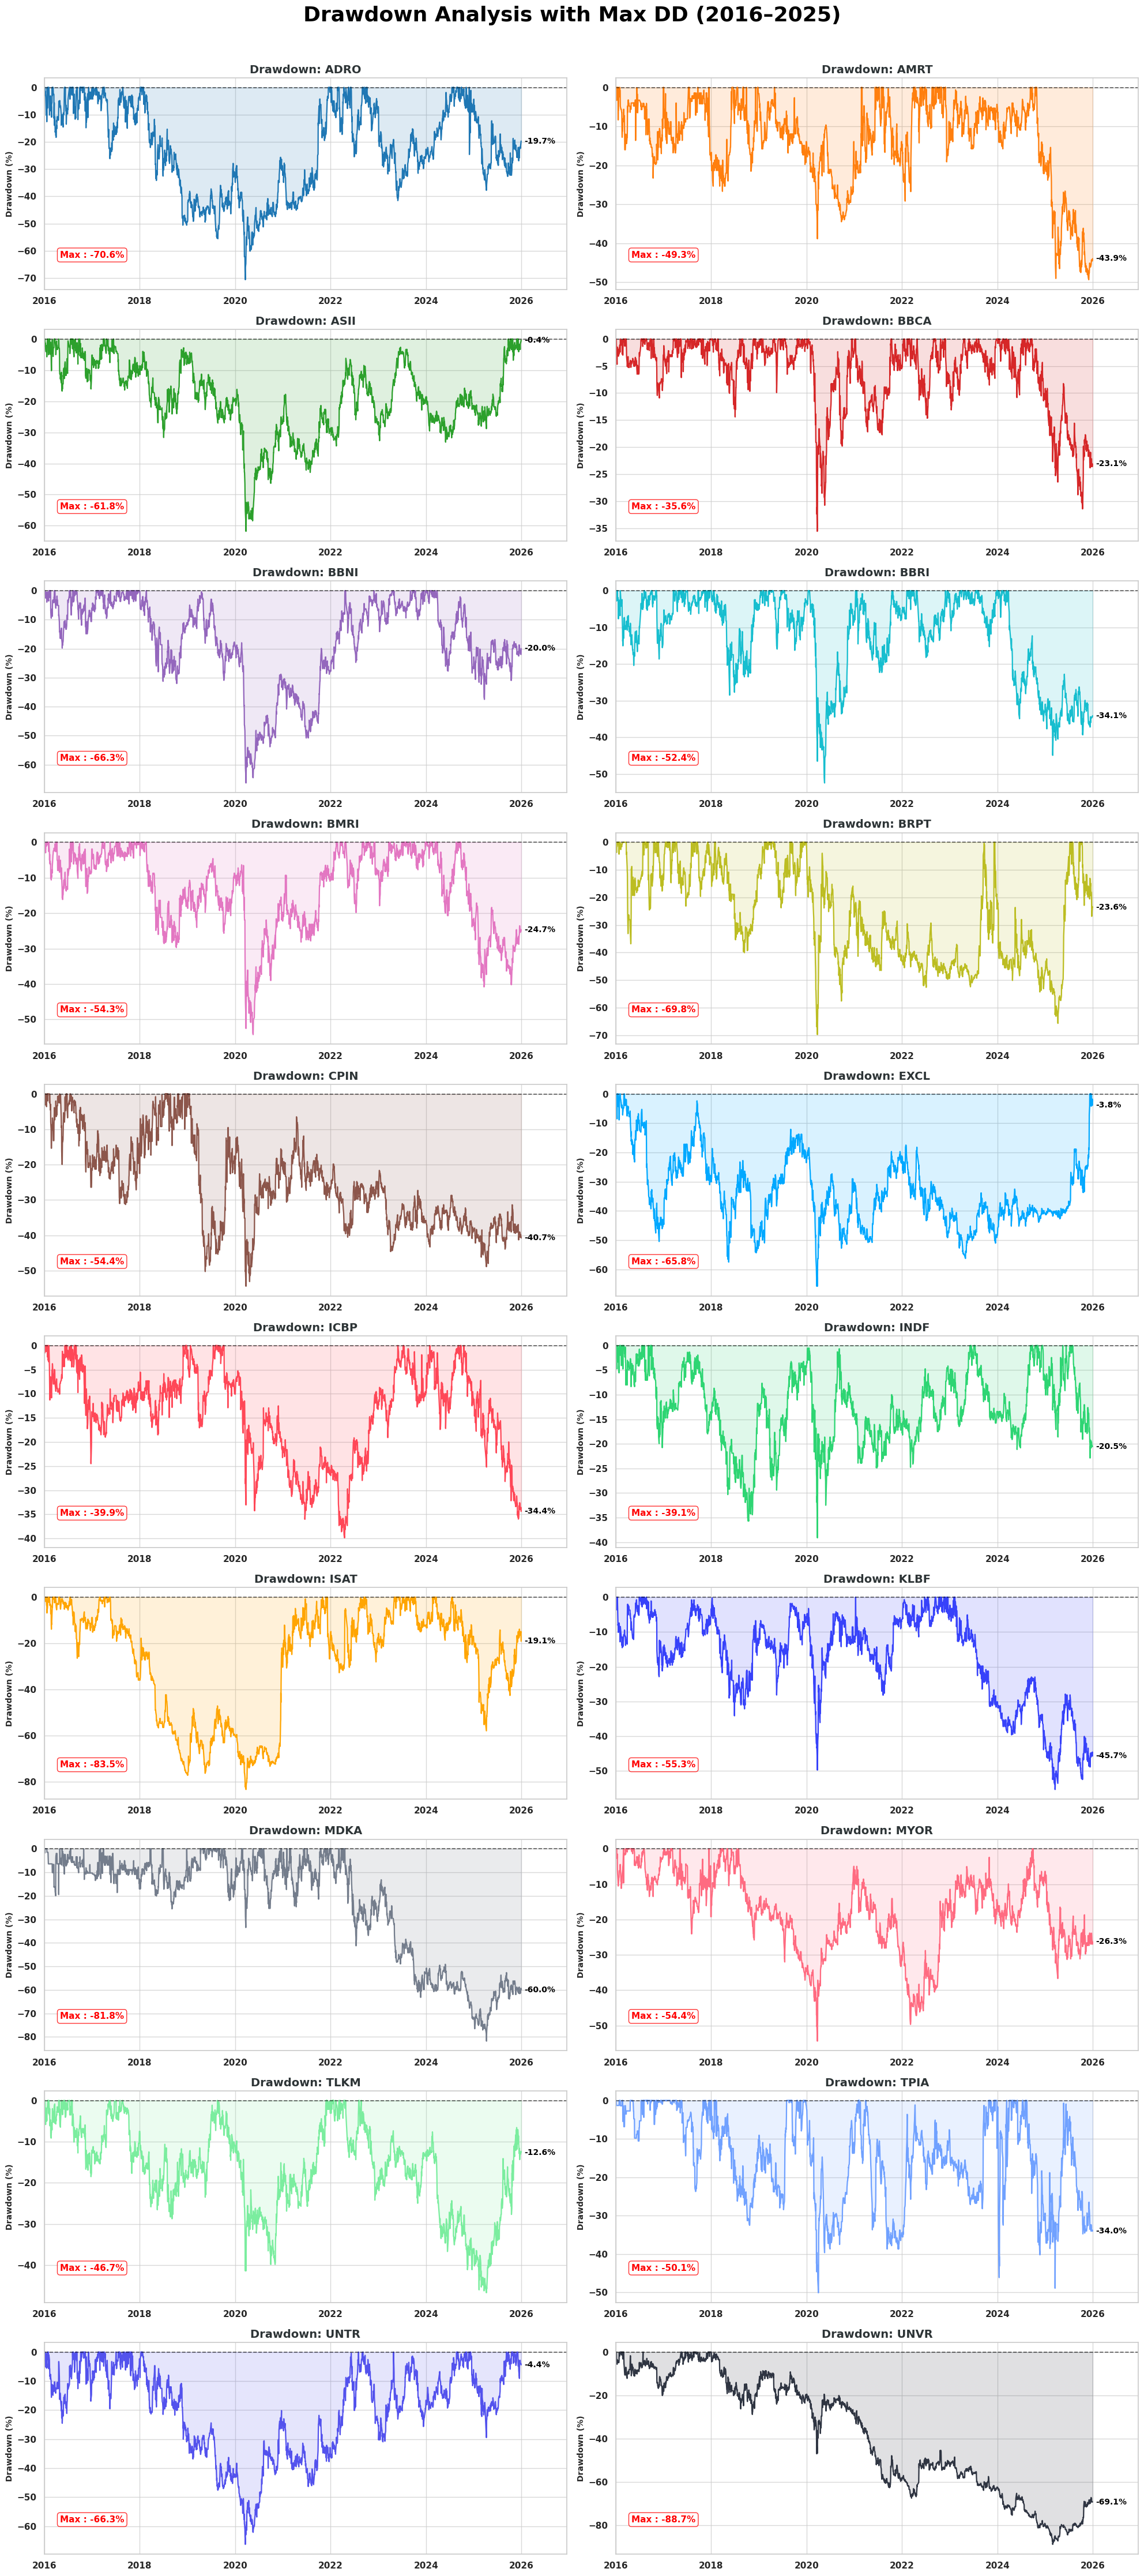

In [28]:
data_drawdown = prices.loc['2016-01-01':'2025-12-31'].copy()
data_drawdown.columns = data_drawdown.columns.str.replace('.JK', '', regex=False)
fig, axes = plt.subplots(10, 2, figsize=(20, 45), facecolor='white')
axes = axes.flatten()

colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#17becf', '#e377c2', '#bcbd22', '#8c564b', '#00a8ff',
    '#ff4757', '#2ed573', '#ffa502', '#3742fa', '#747d8c',
    '#ff6b81', '#7bed9f', '#70a1ff', '#5352ed', '#2f3542'
]

for i, col in enumerate(data_drawdown.columns):
    if i >= len(axes): break

    ax = axes[i]
    price_series = data_drawdown[col].dropna()

    if len(price_series) < 2:
        continue

    rolling_max = price_series.cummax()
    drawdown_pct = (price_series / rolling_max - 1) * 100
    max_dd = drawdown_pct.min()
    ax.plot(drawdown_pct.index, drawdown_pct, linewidth=1.6, color=colors[i])
    ax.fill_between(drawdown_pct.index, drawdown_pct, 0, color=colors[i], alpha=0.15)
    ax.axhline(0, linestyle='--', linewidth=1.2, alpha=0.6, color='black')
    last_date = drawdown_pct.index[-1]
    last_value = drawdown_pct.iloc[-1]
    ax.text(last_date + pd.Timedelta(days=25), last_value, f"{last_value:.1f}%", fontsize=10, fontweight='bold', va='center', color='black')
    ax.text(0.03, 0.15, f"Max : {max_dd:.1f}%", transform=ax.transAxes, fontsize=11, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.3'))
    ax.set_title(f"Drawdown: {col}", fontsize=14, fontweight='bold', color='#2d3436')
    ax.set_ylabel('Drawdown (%)', fontsize=10, fontweight='bold')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, alpha=0.75)
    ax.set_xlim(pd.Timestamp('2016-01-01'), last_date + pd.Timedelta(days=350))

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

fig.suptitle('Drawdown Analysis with Max DD (2016–2025)', fontsize=26, y=0.992, fontweight='bold', color='black')
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()

## **Sharpe Ratio Analysis**

0 Sharpe Ratio
1. Artinya return portofolio sama dengan aset bebas risiko, tidak ada kompensasi untuk risiko.
2. Portofolio tidak menghasilkan keuntungan tambahan dibanding menaruh uang di aset aman.

Sharpe Ratio positif
1. Artinya portofolio memberikan return lebih besar dari risiko yang diambil.
2. Semakin tinggi angkanya, semakin efisien portofolio menghasilkan return per unit risiko.

Sharpe Ratio negatif
1. Artinya portofolio merugi dibanding aset bebas risiko, investor tidak mendapat kompensasi atas risiko yang diambil.
2. Menunjukkan performa portofolio buruk atau strategi tidak efektif.


Semakin tinggi Sharpe Ratio, semakin baik portofolio dalam memanfaatkan risiko untuk menghasilkan return.


Semakin rendah atau negatif, portofolio kurang efisien atau bahkan merugikan.


In [35]:
# prices_eval = prices.loc['2016-01-01':'2025-12-31'].copy()
# prices_eval.columns = prices_eval.columns.str.replace('.JK', '', regex=False)
# window = 60
# trading_days = 252
# risk_free_rate_annual = 0.04
# risk_free_rate_daily = risk_free_rate_annual / trading_days
# fig, axes = plt.subplots(6, 2, figsize=(20, 20))
# axes = axes.flatten()
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#17becf', '#e377c2', '#bcbd22','#8c564b', '#00a8ff', '#ff4757', '#2ed573']

# for i, col in enumerate(prices_eval.columns):
#     ax = axes[i]

#     price_series = prices_eval[col].dropna()
#     if len(price_series) < window + 1:
#         continue

#     daily_returns = price_series.pct_change().dropna()
#     excess_returns = daily_returns - risk_free_rate_daily
#     rolling_sharpe = (excess_returns.rolling(window).mean() / excess_returns.rolling(window).std()) * np.sqrt(trading_days)
#     ax.plot(rolling_sharpe.index,rolling_sharpe,linewidth=1.6,color=colors[i])
#     last_date = rolling_sharpe.dropna().index[-1]
#     last_value = rolling_sharpe.dropna().iloc[-1]
#     ax.text(last_date + pd.Timedelta(days=40),last_value,f"{last_value:.2f}",fontsize=9,fontweight='bold',va='center',color=colors[i])
#     ax.set_title(col, fontsize=12, fontweight='bold')
#     ax.set_ylabel('Sharpe Ratio')
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     ax.grid(True, alpha=0.75)
#     ax.set_xlim(rolling_sharpe.index[0],rolling_sharpe.index[-1] + pd.Timedelta(days=200))

# fig.suptitle('Rolling Sharpe Ratio (60-Day Window & Annualized)',fontsize=16,y=0.995,fontweight='bold')
# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()

## **Volatility Analysis**

0% volatility
1. Artinya harga aset tidak bergerak sama sekali selama periode yang dihitung.
2. Tidak ada fluktuasi harian, portofolio atau saham “stabil sempurna”.
3. Dalam praktik nyata hampir tidak pernah terjadi kecuali saham tidak diperdagangkan.

100% volatility
1. Artinya harga aset bergerak sangat besar dalam setahun.
2. Jika saham bernilai 100, bisa bergerak ±100 dalam setahun.
3. Menunjukkan risiko ekstrem, investasi sangat tidak stabil.


Semakin tinggi persentase, semakin besar fluktuasi dan risiko.

Semakin rendah persentase, harga lebih stabil, risiko lebih kecil.

In [34]:
# data_vol = prices.loc['2016-01-01':'2025-12-31']
# daily_returns = data_vol.pct_change().dropna()
# window = 60
# rolling_vol = daily_returns.rolling(window).std() * np.sqrt(252) * 100
# n_assets = rolling_vol.shape[1]
# n_rows = int(np.ceil(n_assets / 2))
# fig, axes = plt.subplots(6, 2, figsize=(20, 20))
# axes = axes.flatten()
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#17becf', '#e377c2', '#bcbd22','#8c564b', '#00a8ff', '#ff4757', '#2ed573']
# y_ticks = np.arange(0, 126, 25)

# for i, col in enumerate(rolling_vol.columns):
#     ax = axes[i]
#     color = colors[i % len(colors)]
#     ax.plot(rolling_vol.index,rolling_vol[col],linewidth=1.6,color=color)
#     ax.set_title(col.replace('.JK', ''), fontsize=12, fontweight='bold')
#     ax.set_ylim(0, 125)
#     ax.set_yticks(y_ticks)
#     ax.set_ylabel('Annualized Volatility (%)', fontsize=11)
#     ax.tick_params(axis='y', labelleft=True)
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     ax.grid(True, alpha=0.75)
#     last_date = rolling_vol.index[-1]
#     val = rolling_vol[col].iloc[-1]

#     if not np.isnan(val):
#         ax.text(last_date + pd.Timedelta(days=30),val,f"{val:.1f}%",fontsize=9,fontweight='bold',va='center',color=color)

#     ax.set_xlim(rolling_vol.index[0], last_date + pd.Timedelta(days=250))

# for j in range(i + 1, len(axes)):
#     axes[j].axis('off')

# fig.suptitle('Rolling Volatility Analysis (60-Day Window, 2016–2025)',fontsize=16,fontweight='bold',y=0.995)
# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()

## **Correlation Heatmap**

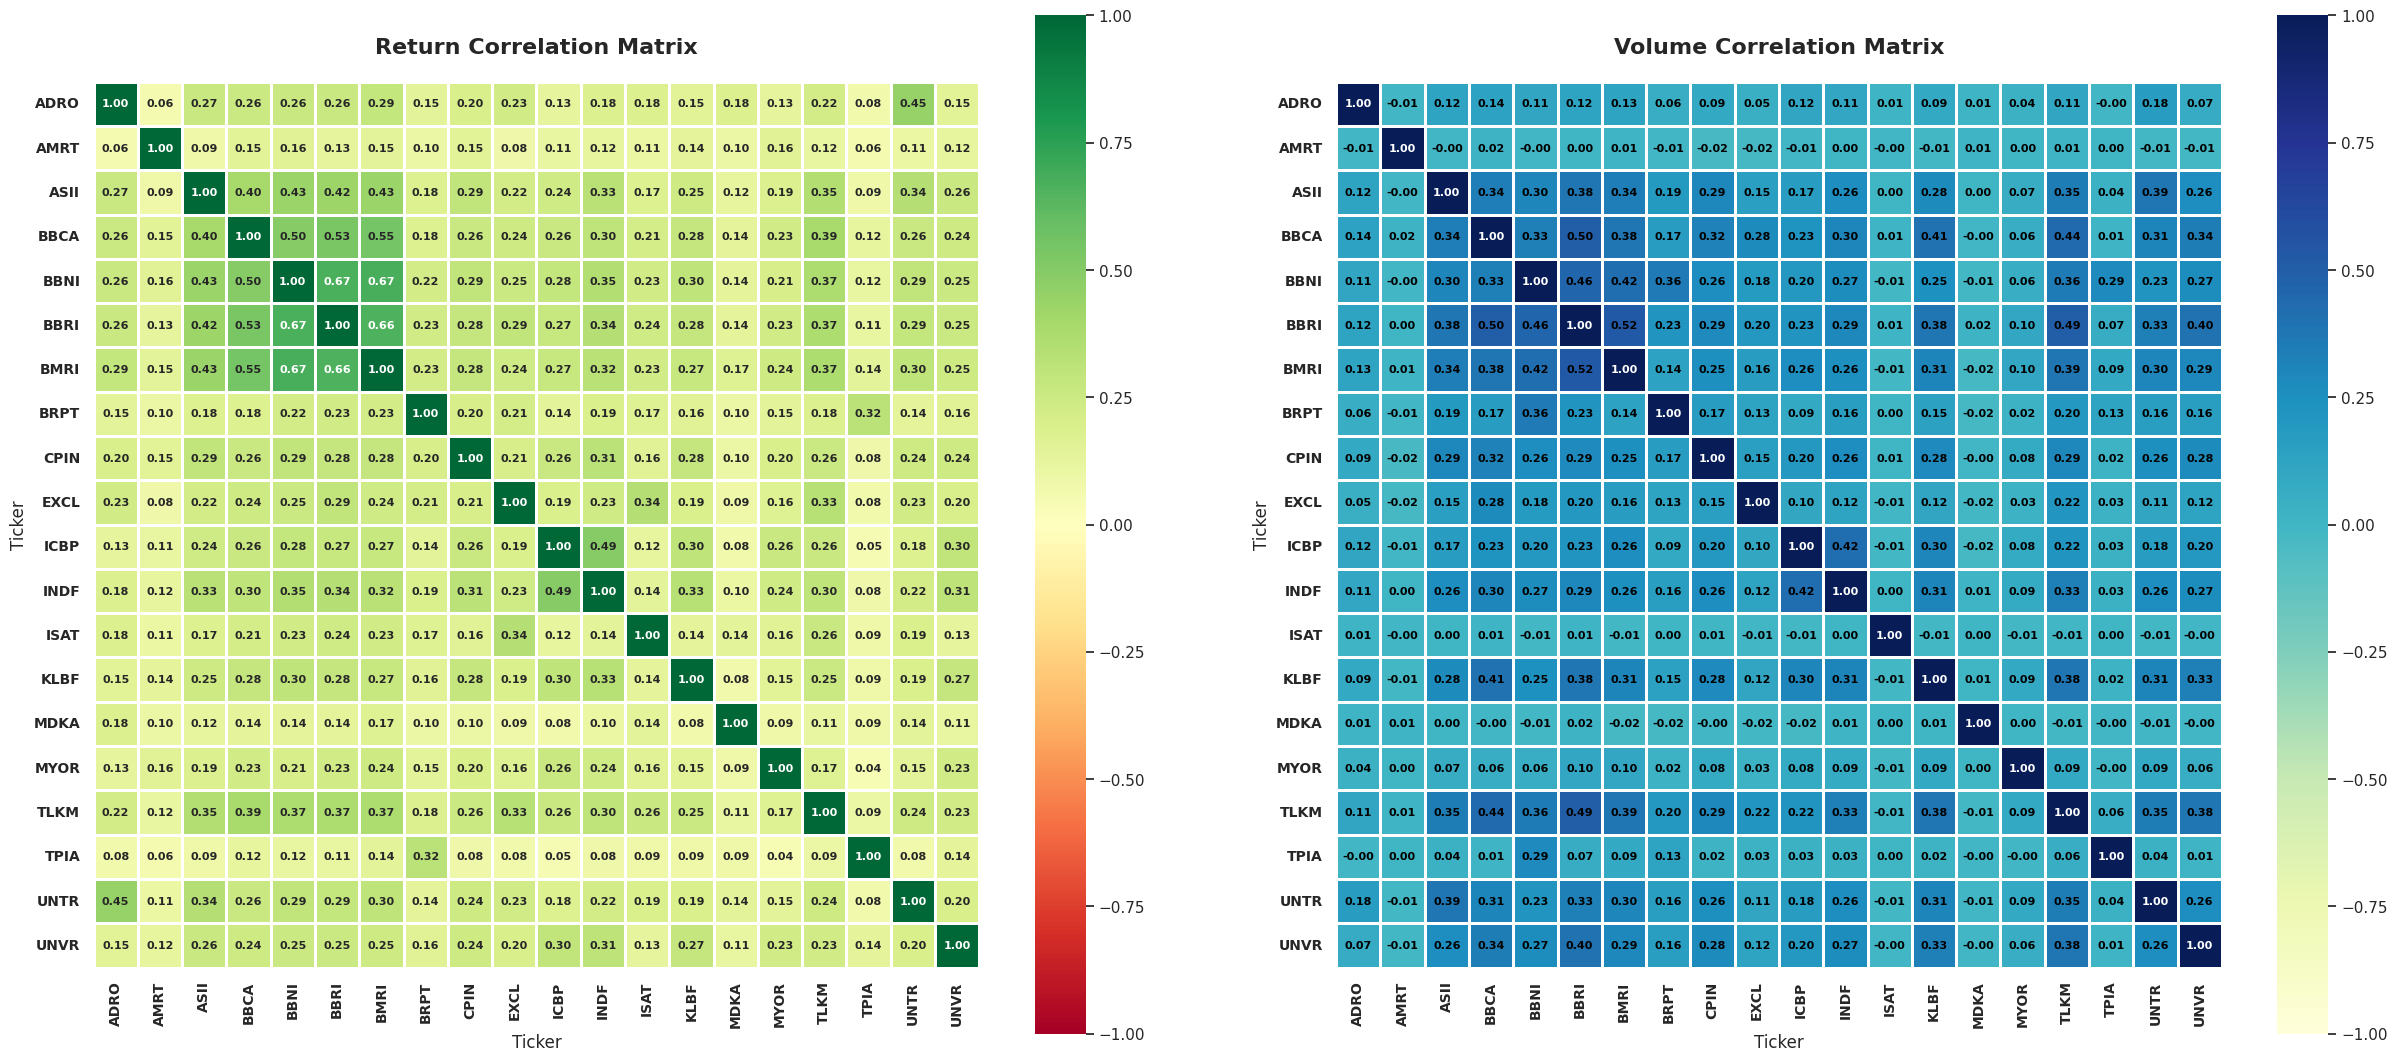

In [33]:
prices_eval = prices.loc['2016-01-01':'2025-12-31']
volumes_eval = volumes.loc['2016-01-01':'2025-12-31']
prices_eval.columns = prices_eval.columns.str.replace('.JK', '', regex=False)
volumes_eval.columns = volumes_eval.columns.str.replace('.JK', '', regex=False)
daily_returns = prices_eval.pct_change().dropna()
corr_return = daily_returns.corr()
corr_volume = volumes_eval.pct_change().replace([np.inf, -np.inf], np.nan).dropna().corr()
fig, axes = plt.subplots(1, 2, figsize=(26, 12), facecolor='white')
sns.heatmap(corr_return, ax=axes[0], annot=True, fmt=".2f", cmap='RdYlGn', vmin=-1, vmax=1, center=0, square=True, linewidths=1, linecolor='white', annot_kws={"fontsize": 8, "fontweight": "bold"})
axes[0].set_title("Return Correlation Matrix", fontsize=16, fontweight='bold', pad=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=10, fontweight='bold')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=10, fontweight='bold')
sns.heatmap(corr_volume, ax=axes[1], annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, square=True, linewidths=1, linecolor='white')

for i in range(corr_volume.shape[0]):
    for j in range(corr_volume.shape[1]):
        value = corr_volume.iloc[i, j]
        text_color = 'white' if value > 0.6 or value < -0.6 else 'black'
        axes[1].text(
            j + 0.5, i + 0.5, f"{value:.2f}",
            ha='center', va='center',
            fontsize=8, fontweight='bold',
            color=text_color
        )

axes[1].set_title("Volume Correlation Matrix", fontsize=16, fontweight='bold', pad=20)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=10, fontweight='bold')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=10, fontweight='bold')
plt.tight_layout(pad=5)
plt.show()

# **Three Dimensional Analysis of Threshold Conditions for Positive Expected Value**

Probability of Win (p) : Probabilitas win dari 0 - 100%

Average Expected Loss % (L) : Rata rata loss yang mungkin terjadi jika
investasi tersebut gagal , semakin ke angka 100 potensi kerugian semakin besar

Min Required Return (R) : target imbal hasil (keuntungan) minimal yang wajib di capai agar secara statistik Anda tidak rugi

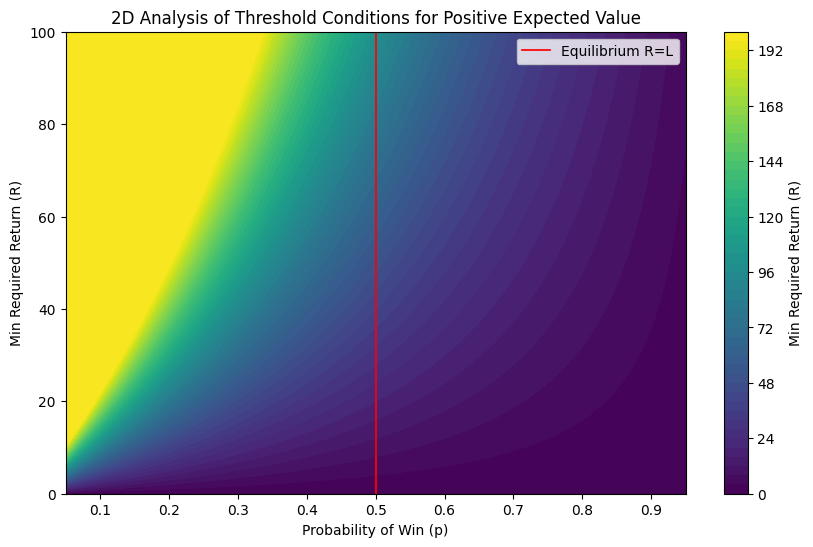

In [ ]:
p = np.linspace(0.05, 0.95, 200)
l = np.linspace(0, 100, 200)
P, L = np.meshgrid(p, l)
R = (L * (1 - P)) / P
R_clipped = np.clip(R, 0, 200)

eq_l_smooth = np.linspace(0, 100, 500)
eq_p_smooth = []

for L_val in eq_l_smooth:
    def f(p):
        return (L_val * (1 - p)) / p - L_val
    p_sol, = fsolve(f, 0.5)
    eq_p_smooth.append(p_sol)

eq_r_smooth = eq_l_smooth
plt.figure(figsize=(10, 6))
cp = plt.contourf(P, L, R_clipped, levels=50, cmap='viridis')
plt.colorbar(cp, label='Min Required Return (R)')
plt.plot(eq_p_smooth, eq_r_smooth, color='red', linewidth=1.25, label='Equilibrium R=L')
plt.xlabel('Probability of Win (p)')
plt.ylabel('Min Required Return (R)')
plt.title('2D Analysis of Threshold Conditions for Positive Expected Value')
plt.legend()
plt.show()

In [ ]:
for L_val in eq_l_smooth:
    def f(p):
        return (L_val * (1 - p)) / p - L_val
    p_sol, = fsolve(f, 0.5)
    eq_p_smooth.append(p_sol)

eq_r_smooth = eq_l_smooth

fig = go.Figure(data=[go.Surface(
    x=P, y=L, z=R_clipped, colorscale='Viridis',
    colorbar=dict(title='Min Required Return (R)'),
    hovertemplate='Prob of Win (p): %{x:.2f}<br>Avg Expected Loss (L): %{y:.2f}%<br>Min Required Return (R): %{z:.2f}%<extra></extra>'
)])

fig.add_trace(go.Scatter3d(
    x=eq_p_smooth,
    y=eq_l_smooth,
    z=eq_r_smooth,
    mode='lines',
    line=dict(color='red', width=4),
    name='Equilibrium',
    hovertemplate='Prob of Win (p): %{x:.2f}<br>Avg Loss (L): %{y:.2f}%<br>R: %{z:.2f}%<extra></extra>'
))

fig.update_layout(
    title='Three-Dimensional Analysis of Threshold Conditions for Positive Expected Value',
    scene=dict(
        xaxis_title='Probability of Win (p)',
        yaxis_title='Average Expected Loss % (L)',
        zaxis_title='Min Required Return (R)',
        xaxis=dict(nticks=10, range=[0, 1], backgroundcolor="rgb(230, 230,230)"),
        yaxis=dict(nticks=10, range=[0, 100], backgroundcolor="rgb(230, 230,230)"),
        zaxis=dict(nticks=10, range=[0, 200], backgroundcolor="rgb(230, 230,230)"),
        aspectratio=dict(x=1, y=1, z=0.8),
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()